## Importing Libraries

In [1]:
! pip install sqlalchemy
! pip install PyMySQL

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sb

import pymysql
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

import getpass
password = getpass.getpass()

········


In [3]:
# Creating a connection to use Sakila database from MySQL

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

### In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [4]:
# Step 1: Create a query or queries to extract the information you think may be relevant for building the prediction model.

query = '''

WITH COUNT AS (SELECT DISTINCT A.FILM_ID,
                               SUBSTRING(C.RENTAL_DATE, 1, 7)    AS RENTAL_MONTH,
                               COUNT(DISTINCT C.RENTAL_ID)       AS RENTAL_COUNT
               FROM SAKILA.FILM A
                        INNER JOIN
                    SAKILA.INVENTORY B ON A.FILM_ID = B.FILM_ID
                        INNER JOIN
                    SAKILA.RENTAL C ON B.INVENTORY_ID = C.INVENTORY_ID
               GROUP BY 1, 2)

SELECT DISTINCT
    A.FILM_ID,
    A.TITLE,
    A.RELEASE_YEAR,
    A.RENTAL_DURATION,
    A.RENTAL_RATE,
    A.REPLACEMENT_COST,
    A.RATING,
    E.NAME,
    SUM(CASE
        WHEN RENTAL_MONTH IN ('2005-05' , '2005-06', '2005-07', '2005-08') THEN RENTAL_COUNT
        ELSE 0
    END) AS TOTAL_RENTAL,
    SUM(CASE
        WHEN RENTAL_MONTH = '2005-05' THEN RENTAL_COUNT
        ELSE 0
    END) AS RENTAL_MAY05,
    SUM(CASE
        WHEN RENTAL_MONTH = '2005-06' THEN RENTAL_COUNT
        ELSE 0
    END) AS RENTAL_JUN05,
    SUM(CASE
        WHEN RENTAL_MONTH = '2005-07' THEN RENTAL_COUNT
        ELSE 0
    END) AS RENTAL_JUL05,
    SUM(CASE
        WHEN RENTAL_MONTH = '2005-08' THEN RENTAL_COUNT
        ELSE 0
    END) AS RENTAL_AUG05,
    SUM(CASE
        WHEN RENTAL_MONTH = '2006-02' THEN RENTAL_COUNT
        ELSE 0
    END) AS RENTAL_FEB06
FROM
    SAKILA.FILM A
        INNER JOIN
    COUNT B ON A.FILM_ID = B.FILM_ID
        INNER JOIN
    SAKILA.FILM_CATEGORY D ON A.FILM_ID = D.FILM_ID
        INNER JOIN
    SAKILA.CATEGORY E ON D.CATEGORY_ID = E.CATEGORY_ID
GROUP BY 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8

'''

# Step 2: Read the data into a Pandas dataframe.

data = pd.read_sql_query(query, engine)
data

,FILM_ID,TITLE,RELEASE_YEAR,RENTAL_DURATION,RENTAL_RATE,REPLACEMENT_COST,RATING,NAME,TOTAL_RENTAL,RENTAL_MAY05,RENTAL_JUN05,RENTAL_JUL05,RENTAL_AUG05,RENTAL_FEB06
0,19,AMADEUS HOLY,2006,6,0.99,20.99,PG,Action,20.0,1.0,4.0,8.0,7.0,1.0
1,21,AMERICAN CIRCUS,2006,3,4.99,17.99,R,Action,21.0,2.0,3.0,8.0,8.0,1.0
2,29,ANTITRUST TOMATOES,2006,5,2.99,11.99,NC-17,Action,10.0,2.0,2.0,4.0,2.0,0.0
3,56,BAREFOOT MANCHURIAN,2006,6,2.99,15.99,G,Action,18.0,1.0,3.0,8.0,6.0,0.0
4,67,BERETS AGENT,2006,5,2.99,24.99,PG-13,Action,20.0,1.0,2.0,11.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,931,VALENTINE VANISHING,2006,7,0.99,9.99,PG-13,Travel,12.0,2.0,2.0,3.0,5.0,0.0
954,977,WINDOW SIDE,2006,3,2.99,25.99,R,Travel,11.0,0.0,3.0,6.0,2.0,1.0
955,981,WOLVES DESIRE,2006,7,0.99,13.99,NC-17,Travel,21.0,0.0,4.0,9.0,8.0,0.0
956,988,WORKER TARZAN,2006,7,2.99,26.99,R,Travel,15.0,0.0,2.0,6.0,7.0,0.0


In [5]:
# Step 3: Analyze extracted features and transform them.

In [6]:
data = data.set_index('FILM_ID')
data

,TITLE,RELEASE_YEAR,RENTAL_DURATION,RENTAL_RATE,REPLACEMENT_COST,RATING,NAME,TOTAL_RENTAL,RENTAL_MAY05,RENTAL_JUN05,RENTAL_JUL05,RENTAL_AUG05,RENTAL_FEB06
FILM_ID,,,,,,,,,,,,,
19,AMADEUS HOLY,2006,6,0.99,20.99,PG,Action,20.0,1.0,4.0,8.0,7.0,1.0
21,AMERICAN CIRCUS,2006,3,4.99,17.99,R,Action,21.0,2.0,3.0,8.0,8.0,1.0
29,ANTITRUST TOMATOES,2006,5,2.99,11.99,NC-17,Action,10.0,2.0,2.0,4.0,2.0,0.0
56,BAREFOOT MANCHURIAN,2006,6,2.99,15.99,G,Action,18.0,1.0,3.0,8.0,6.0,0.0
67,BERETS AGENT,2006,5,2.99,24.99,PG-13,Action,20.0,1.0,2.0,11.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,VALENTINE VANISHING,2006,7,0.99,9.99,PG-13,Travel,12.0,2.0,2.0,3.0,5.0,0.0
977,WINDOW SIDE,2006,3,2.99,25.99,R,Travel,11.0,0.0,3.0,6.0,2.0,1.0
981,WOLVES DESIRE,2006,7,0.99,13.99,NC-17,Travel,21.0,0.0,4.0,9.0,8.0,0.0


In [7]:
data.isna().sum()

TITLE               0
RELEASE_YEAR        0
RENTAL_DURATION     0
RENTAL_RATE         0
REPLACEMENT_COST    0
RATING              0
NAME                0
TOTAL_RENTAL        0
RENTAL_MAY05        0
RENTAL_JUN05        0
RENTAL_JUL05        0
RENTAL_AUG05        0
RENTAL_FEB06        0
dtype: int64

In [8]:
data.dtypes

TITLE                object
RELEASE_YEAR          int64
RENTAL_DURATION       int64
RENTAL_RATE         float64
REPLACEMENT_COST    float64
RATING               object
NAME                 object
TOTAL_RENTAL        float64
RENTAL_MAY05        float64
RENTAL_JUN05        float64
RENTAL_JUL05        float64
RENTAL_AUG05        float64
RENTAL_FEB06        float64
dtype: object

In [9]:
data.describe()

,RELEASE_YEAR,RENTAL_DURATION,RENTAL_RATE,REPLACEMENT_COST,TOTAL_RENTAL,RENTAL_MAY05,RENTAL_JUN05,RENTAL_JUL05,RENTAL_AUG05,RENTAL_FEB06
count,958.0,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,2006.0,4.969729,2.977474,20.059937,16.557411,1.206681,2.412317,7.003132,5.935282,0.189979
std,0.0,1.407593,1.643152,6.059985,6.623660,1.048000,1.385148,2.933429,2.534194,0.428142
min,2006.0,3.000000,0.990000,9.990000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2006.0,4.000000,0.990000,14.990000,11.000000,0.000000,1.000000,5.000000,4.000000,0.000000
50%,2006.0,5.000000,2.990000,19.990000,16.000000,1.000000,2.000000,7.000000,6.000000,0.000000
75%,2006.0,6.000000,4.990000,24.990000,21.000000,2.000000,3.000000,9.000000,8.000000,0.000000
max,2006.0,7.000000,4.990000,29.990000,34.000000,5.000000,7.000000,16.000000,13.000000,2.000000


We see how mean value for the number of times each was rented increase significantly from May 2005 to August 2005. Also, all films we rented at least 1 time in July 2005 and August 2005. We will drop Feb 2006 as we don't have timeline trends to compare against. On average, each movie has been rented 17 times.

In [10]:
data['TOTAL_RENTAL'].value_counts().sort_values()

34.0     1
33.0     1
32.0     3
4.0      3
30.0    10
31.0    11
29.0    13
27.0    16
5.0     18
28.0    18
24.0    27
25.0    27
26.0    32
6.0     32
7.0     35
23.0    36
22.0    38
8.0     38
12.0    39
18.0    40
10.0    41
11.0    41
9.0     41
19.0    42
20.0    44
16.0    47
14.0    49
13.0    51
21.0    51
15.0    53
17.0    60
Name: TOTAL_RENTAL, dtype: int64

Between May 2005 and August 2005, all movies hve been rented, the minimum was 4 times. This is an issue with imbalanced data, as there is no movie without rental, so we can't predict if it will be rented.

In [11]:
data['RELEASE_YEAR'].value_counts()

2006    958
Name: RELEASE_YEAR, dtype: int64

All films are released in 2006, hence we can drop this column for our analysis. However it's interesting to understand what "release year" means as we have rentals hapenning in 2005.

In [12]:
data['RENTAL_MAY05'].value_counts()

1.0    355
0.0    272
2.0    225
3.0     76
4.0     27
5.0      3
Name: RENTAL_MAY05, dtype: int64

In [13]:
data['RENTAL_JUN05'].value_counts()

2.0    275
3.0    222
1.0    206
4.0    118
0.0     58
5.0     58
6.0     20
7.0      1
Name: RENTAL_JUN05, dtype: int64

In [14]:
data['RENTAL_JUL05'].value_counts()

6.0     127
8.0     110
7.0     107
4.0     104
5.0      99
3.0      87
9.0      82
10.0     80
11.0     60
12.0     35
2.0      30
14.0     16
13.0     15
1.0       3
15.0      2
16.0      1
Name: RENTAL_JUL05, dtype: int64

In [15]:
data['RENTAL_AUG05'].value_counts()

5.0     137
6.0     136
3.0     117
8.0     110
4.0     107
7.0      99
9.0      85
2.0      75
10.0     49
11.0     24
12.0     11
1.0       6
13.0      2
Name: RENTAL_AUG05, dtype: int64

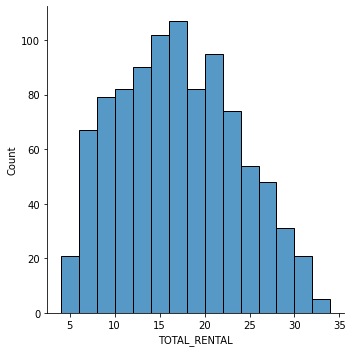

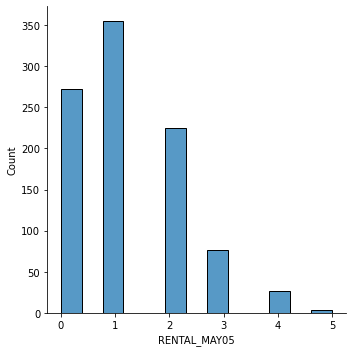

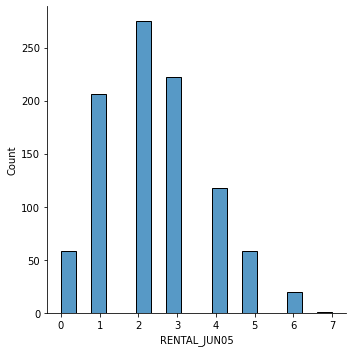

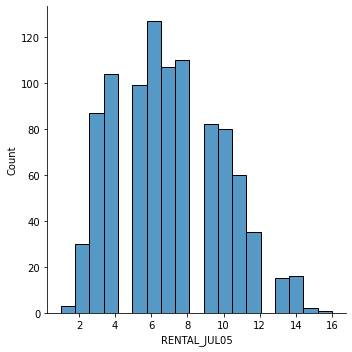

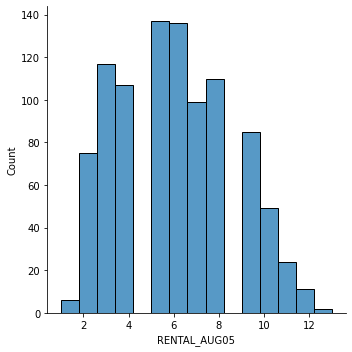

In [16]:
for col in ['TOTAL_RENTAL', 'RENTAL_MAY05',
       'RENTAL_JUN05', 'RENTAL_JUL05', 'RENTAL_AUG05']:
    sb.displot(data[col])
    plt.show()

All films have been rented during July and August, hence our prediction would always be 1. We do see a positive linear trend over time, meaning that month after month more movies get rented and each movie gets rented more times. 

### Logistic Regression

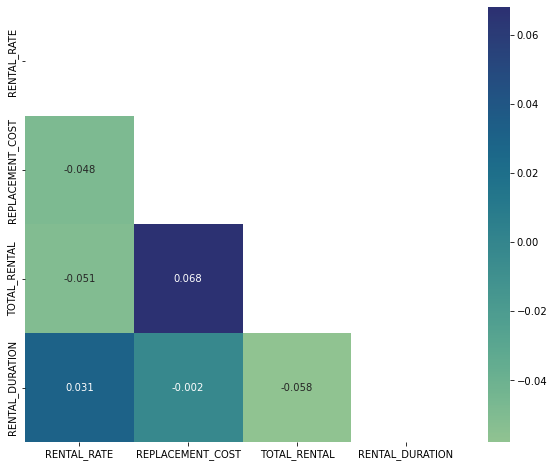

In [28]:
# correlation matrix for numerical features
import numpy as np

num_corr = data[['RENTAL_RATE','REPLACEMENT_COST','TOTAL_RENTAL','RENTAL_DURATION']].corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sb.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="crest")
plt.show()

In [ ]:
# We want to predict if a movie will be rented based on the rental rate and the replacement cost

In [31]:
# we load our previous dataset into a SQL console
df = data
df.to_sql('films', engine,if_exists = 'replace')
df.head()

,TITLE,RELEASE_YEAR,RENTAL_DURATION,RENTAL_RATE,REPLACEMENT_COST,RATING,NAME,TOTAL_RENTAL,RENTAL_MAY05,RENTAL_JUN05,RENTAL_JUL05,RENTAL_AUG05,RENTAL_FEB06
FILM_ID,,,,,,,,,,,,,
19,AMADEUS HOLY,2006,6,0.99,20.99,PG,Action,20.0,1.0,4.0,8.0,7.0,1.0
21,AMERICAN CIRCUS,2006,3,4.99,17.99,R,Action,21.0,2.0,3.0,8.0,8.0,1.0
29,ANTITRUST TOMATOES,2006,5,2.99,11.99,NC-17,Action,10.0,2.0,2.0,4.0,2.0,0.0
56,BAREFOOT MANCHURIAN,2006,6,2.99,15.99,G,Action,18.0,1.0,3.0,8.0,6.0,0.0
67,BERETS AGENT,2006,5,2.99,24.99,PG-13,Action,20.0,1.0,2.0,11.0,6.0,1.0


In [34]:
sql = '''
select distinct *
, case when RENTAL_MAY05 > 0 then 1 else 0 end as rented_in_may
, case when RENTAL_JUN05 > 0 then 1 else 0 end as rented_in_june
, case when RENTAL_JUL05 > 0 then 1 else 0 end as rented_in_july
, case when RENTAL_AUG05 > 0 then 1 else 0 end as rented_in_august

from films
'''
df_model = pd.read_sql_query(sql, engine)
df_model

,FILM_ID,TITLE,RELEASE_YEAR,RENTAL_DURATION,RENTAL_RATE,REPLACEMENT_COST,RATING,NAME,TOTAL_RENTAL,RENTAL_MAY05,RENTAL_JUN05,RENTAL_JUL05,RENTAL_AUG05,RENTAL_FEB06,rented_in_may,rented_in_june,rented_in_july,rented_in_august
0,19,AMADEUS HOLY,2006,6,0.99,20.99,PG,Action,20.0,1.0,4.0,8.0,7.0,1.0,1,1,1,1
1,21,AMERICAN CIRCUS,2006,3,4.99,17.99,R,Action,21.0,2.0,3.0,8.0,8.0,1.0,1,1,1,1
2,29,ANTITRUST TOMATOES,2006,5,2.99,11.99,NC-17,Action,10.0,2.0,2.0,4.0,2.0,0.0,1,1,1,1
3,56,BAREFOOT MANCHURIAN,2006,6,2.99,15.99,G,Action,18.0,1.0,3.0,8.0,6.0,0.0,1,1,1,1
4,67,BERETS AGENT,2006,5,2.99,24.99,PG-13,Action,20.0,1.0,2.0,11.0,6.0,1.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,931,VALENTINE VANISHING,2006,7,0.99,9.99,PG-13,Travel,12.0,2.0,2.0,3.0,5.0,0.0,1,1,1,1
954,977,WINDOW SIDE,2006,3,2.99,25.99,R,Travel,11.0,0.0,3.0,6.0,2.0,1.0,0,1,1,1
955,981,WOLVES DESIRE,2006,7,0.99,13.99,NC-17,Travel,21.0,0.0,4.0,9.0,8.0,0.0,0,1,1,1
956,988,WORKER TARZAN,2006,7,2.99,26.99,R,Travel,15.0,0.0,2.0,6.0,7.0,0.0,0,1,1,1


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

X = pd.get_dummies(df_model[['RENTAL_RATE','REPLACEMENT_COST','rented_in_may','RENTAL_DURATION']])

y = df_model['rented_in_june']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=60, stratify=y)

classification = LogisticRegression(random_state=60, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.94      1.00      0.97       271

    accuracy                           0.94       288
   macro avg       0.47      0.50      0.48       288
weighted avg       0.89      0.94      0.91       288



When using a logistic regression model to predict films that will be rented in June, we get an accuracy of 94.0%